<a href="https://colab.research.google.com/github/kostas696/My_Latest_Projects/blob/main/Project_Movie_Genre_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project: Movie Genre Classification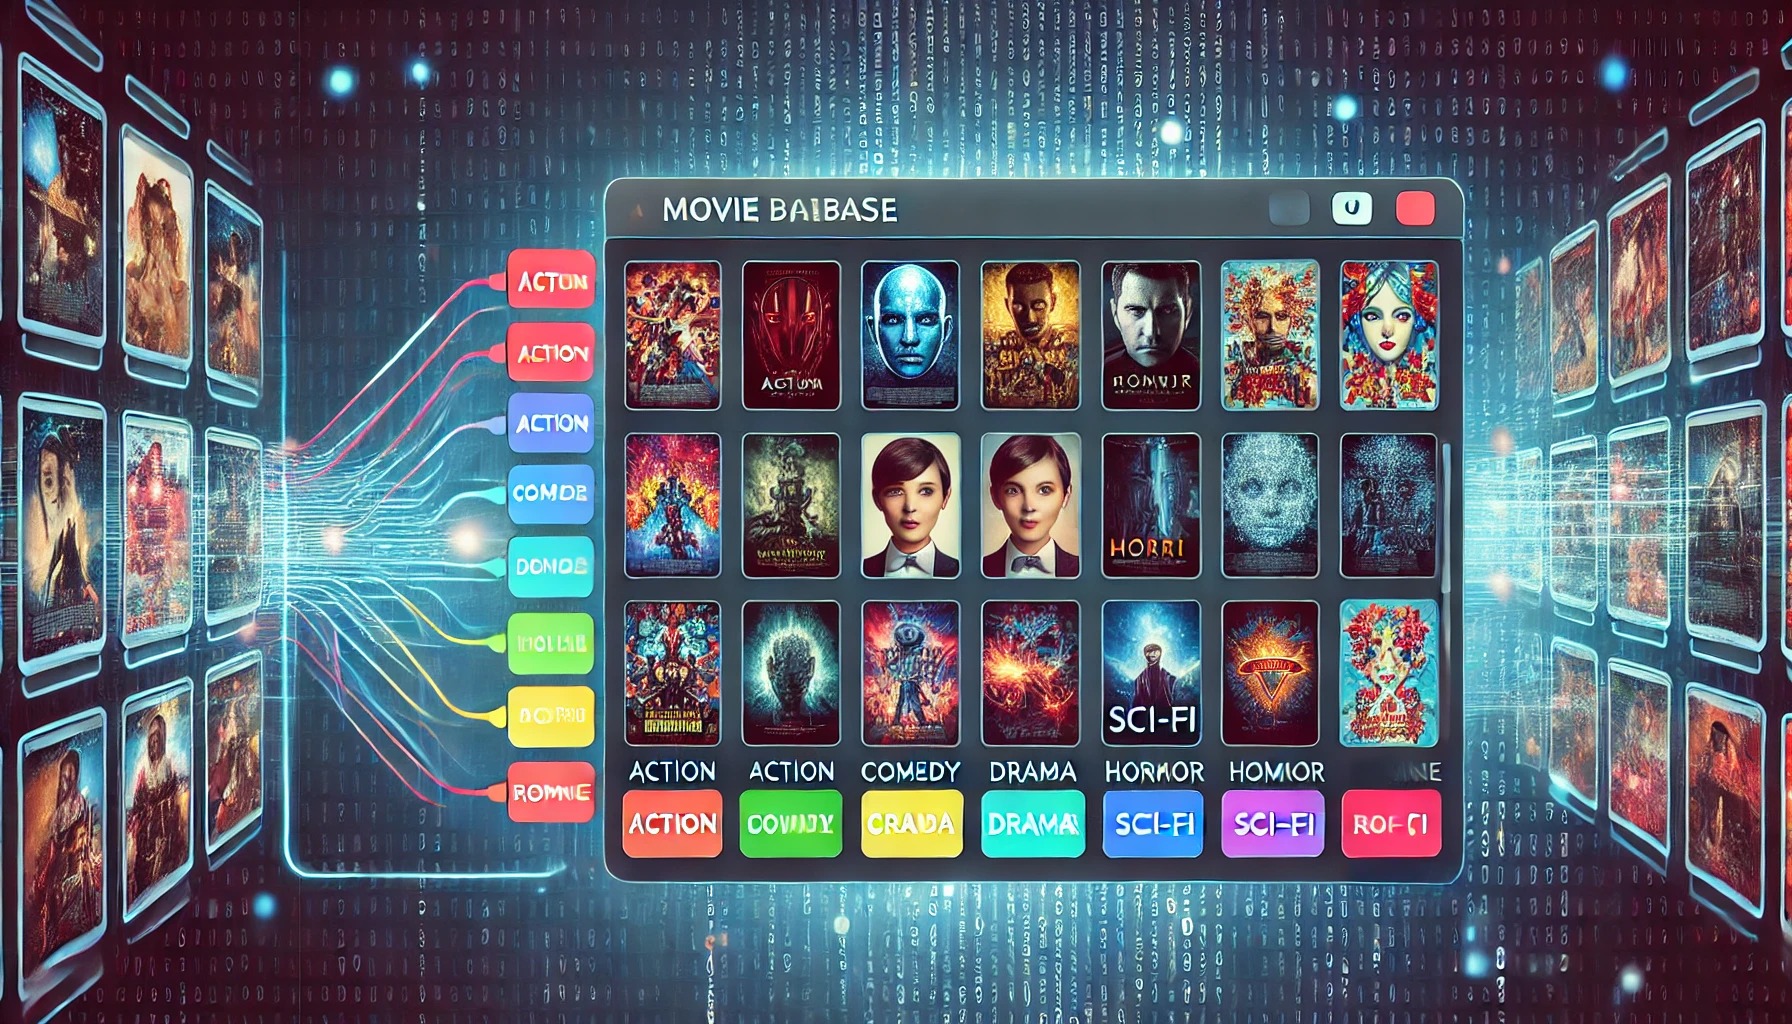**

## Introduction

In the rapidly evolving field of machine learning and natural language processing (NLP), one of the most compelling challenges is the automatic classification of movie genres based on their descriptions. Given the vast amount of content available on platforms like IMDb, efficient and accurate classification methods are essential for content management and user recommendation systems. This project explores various machine learning models and feature extraction techniques to classify movie genres, leveraging the power of TF-IDF, Word2Vec, and GloVe embeddings.

## Objective

The primary objective of this project is to develop and evaluate different machine learning models for the classification of movie genres based on their descriptions. The aim is to identify the most effective feature extraction method and model combination that delivers the highest classification accuracy. Additionally, hyperparameter tuning will be performed on the best-performing model to further enhance its performance.

## Dataset Information

The dataset used in this project is the "Genre Classification Dataset" from IMDb, sourced from Kaggle. It includes training data, test data, and a test data solution with the following attributes:

- ID: A unique identifier for each movie.
- Title: The title of the movie.
- Genre: The genre of the movie (available in the training data and test data solution).
- Description: A brief description of the movie.

The dataset contains various genres, including action, comedy, drama, and documentary, among others. The training dataset is used to build and train the models, while the test dataset is used for model evaluation.

## Research Question

The primary research question guiding this project is:

- Which combination of feature extraction method and machine learning model yields the highest accuracy for movie genre classification based on descriptions?

Secondary questions include:

- How does the performance of different models vary with different feature extraction methods?

## Approach of Analysis

The analysis follows a structured approach involving data preprocessing, feature extraction, model training, evaluation, and hyperparameter tuning:

**Data Preprocessing**
- Loading the Dataset: The dataset is loaded and inspected for any missing or duplicate values.
- Extracting and Cleaning Titles and Dates: Titles and dates are extracted and cleaned to ensure consistency.
- Description Length Analysis: Analyzing the length of descriptions to understand the data distribution.

**Feature Extraction**
- TF-IDF Vectorization: Term Frequency-Inverse Document Frequency (TF-IDF) is used to convert text data into numerical features.
- Word2Vec Embeddings: Pre-trained Word2Vec embeddings are used to convert text data into vector representations.
- GloVe Embeddings: Pre-trained GloVe embeddings are used for feature extraction.

**Model Training and Evaluation**
- Logistic Regression: A basic yet powerful model is trained and evaluated using each feature extraction method.
- Support Vector Machine (SVM): Known for its effectiveness in text classification, SVM is applied and evaluated.
- Random Forest: An ensemble method that combines multiple decision trees for better accuracy.
- XGBoost: An advanced boosting algorithm that is evaluated for its performance.

**Model Saving and Loading**

The trained models and results are saved to disk and Google Drive for future use and reproducibility.

By following this approach, we aim to identify the optimal feature extraction method and machine learning model for the task of movie genre classification, providing insights into the effectiveness of different techniques and the potential impact of hyperparameter tuning on model performance.

## Imports

In [ ]:
!pip install transformers

In [ ]:
!pip install -q opendatasets

In [ ]:
!pip install --q IMDbPY

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import re

import transformers as ppb
import os
import requests
import zipfile
import joblib

import opendatasets as od
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from transformers import BertTokenizer, BertModel
import torch
import xgboost as xgb
from gensim.models import Word2Vec
import gensim.downloader as api


# Set plotting size and style
sns.set(rc = {'figure.figsize':(16, 8)})
sns.set_style("darkgrid")

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [ ]:
# Import our dataset straight from kaggle
od.download('https://www.kaggle.com/datasets/hijest/genre-classification-dataset-imdb/data')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: kostas696
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/hijest/genre-classification-dataset-imdb


100%|██████████| 41.7M/41.7M [00:00<00:00, 74.5MB/s]


In [ ]:
# Loading training and test data
train_data = pd.read_csv('/content/genre-classification-dataset-imdb/Genre Classification Dataset/train_data.txt', sep=':::', names=['ID','Title', 'Genre', 'Description'], engine='python')
test_data = pd.read_csv('/content/genre-classification-dataset-imdb/Genre Classification Dataset/test_data.txt', sep=':::', names=['ID', 'Title', 'Description'], engine='python')
test_data_solution = pd.read_csv('/content/genre-classification-dataset-imdb/Genre Classification Dataset/test_data_solution.txt', sep=':::', names=['ID','Title', 'Genre', 'Description'], engine='python')

In [ ]:
# Preview our dataset
train_data.head()

,ID,Title,Genre,Description
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


In [ ]:
# Check the general info of our dataset
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54214 entries, 0 to 54213
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           54214 non-null  int64 
 1   Title        54214 non-null  object
 2   Genre        54214 non-null  object
 3   Description  54214 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.7+ MB


In [ ]:
# Check for null values
train_data.isnull().sum()

ID             0
Title          0
Genre          0
Description    0
dtype: int64

In [ ]:
# Check for duplicate values
train_data.duplicated().sum()

0

## Data Preprocessing

In [ ]:
# Function to extract title and date
def extract_title_and_date(df):
    # Extract dates in (YEAR) format
    df['Date'] = df['Title'].apply(lambda x: re.search(r'\((\d{4})\)', x).group(1) if re.search(r'\((\d{4})\)', x) else None)

    # Handle titles with (????) and treat them as missing dates
    df['Title'] = df['Title'].apply(lambda x: re.sub(r'\(\?\?\?\?\)', '', x))

    # Extract dates in YEARX format at the end of the title
    df.loc[df['Date'].isna(), 'Date'] = df['Title'].apply(lambda x: re.search(r'\b(\d{4})([A-Za-z]*)\b', x).group(1) if re.search(r'\b(\d{4})([A-Za-z]*)\b', x) else None)

    # Clean the title by removing dates and attached characters
    df['Title'] = df['Title'].apply(lambda x: re.sub(r'\s*\(\d{4}\)\s*', '', x))
    df['Title'] = df['Title'].apply(lambda x: re.sub(r'\b(\d{4})([A-Za-z]*)\b', '', x).strip())

    return df

In [ ]:
# Apply the function to our dataset
extract_title_and_date(train_data)

,ID,Title,Genre,Description,Date
0,1,Oscar et la dame rose,drama,Listening in to a conversation between his do...,2009
1,2,Cupid,thriller,A brother and sister with a past incestuous r...,1997
2,3,"Young, Wild and Wonderful",adult,As the bus empties the students for their fie...,1980
3,4,The Secret Sin,drama,To help their unemployed father make ends mee...,1915
4,5,The Unrecovered,drama,The film's title refers not only to the un-re...,2007
...,...,...,...,...,...
54209,54210,"""Bonino""",comedy,This short-lived NBC live sitcom centered on ...,1953
54210,54211,Dead Girls Don't Cry,horror,The NEXT Generation of EXPLOITATION. The sist...,None
54211,54212,Ronald Goedemondt: Ze bestaan echt,documentary,"Ze bestaan echt, is a stand-up comedy about g...",2008
54212,54213,Make Your Own Bed,comedy,Walter and Vivian live in the country and hav...,1944


In [ ]:
# Function to clean the title
def clean_title(title):
    # Remove unwanted symbols
    title = re.sub(r'["“”]', '', title)  # Remove quotation marks
    title = re.sub(r'[^\w\s]', '', title)  # Remove non-alphanumeric characters except spaces
    title = re.sub(r'\s+', ' ', title).strip()  # Remove extra spaces
    return title

In [ ]:
# Cleaning the title
train_data['Title'] = train_data['Title'].apply(clean_title)
train_data['Title']

0                    Oscar et la dame rose
1                                    Cupid
2                 Young Wild and Wonderful
3                           The Secret Sin
4                          The Unrecovered
                       ...                
54209                               Bonino
54210                  Dead Girls Dont Cry
54211    Ronald Goedemondt Ze bestaan echt
54212                    Make Your Own Bed
54213    Natures Fury Storm of the Century
Name: Title, Length: 54214, dtype: object

In [ ]:
# Preview the result of our function
train_data[9:]

,ID,Title,Genre,Description,Date
9,10,Spirits I,horror,Four high school students embark on a terrify...,2014
10,11,The Spirit World Ghana,documentary,Tom Beacham explores Ghana with Director of P...,2016
11,12,In the Gloaming,drama,"Danny, dying of Aids, returns home for his la...",1997
12,13,Pink Ribbons One Small Step,documentary,A sister's breast cancer diagnosis and her br...,2009
13,14,Interrabang,thriller,"A photographer is sailing with his wife, her ...",1969
...,...,...,...,...,...
54209,54210,Bonino,comedy,This short-lived NBC live sitcom centered on ...,1953
54210,54211,Dead Girls Dont Cry,horror,The NEXT Generation of EXPLOITATION. The sist...,None
54211,54212,Ronald Goedemondt Ze bestaan echt,documentary,"Ze bestaan echt, is a stand-up comedy about g...",2008
54212,54213,Make Your Own Bed,comedy,Walter and Vivian live in the country and hav...,1944


In [ ]:
# Check the distribution of genres
genre_counts = train_data['Genre'].value_counts()
print("Genre Distribution:\n", genre_counts)

Genre Distribution:
 Genre
 drama           13613
 documentary     13096
 comedy           7447
 short            5073
 horror           2204
 thriller         1591
 action           1315
 western          1032
 reality-tv        884
 family            784
 adventure         775
 music             731
 romance           672
 sci-fi            647
 adult             590
 crime             505
 animation         498
 sport             432
 talk-show         391
 fantasy           323
 mystery           319
 musical           277
 biography         265
 history           243
 game-show         194
 news              181
 war               132
Name: count, dtype: int64


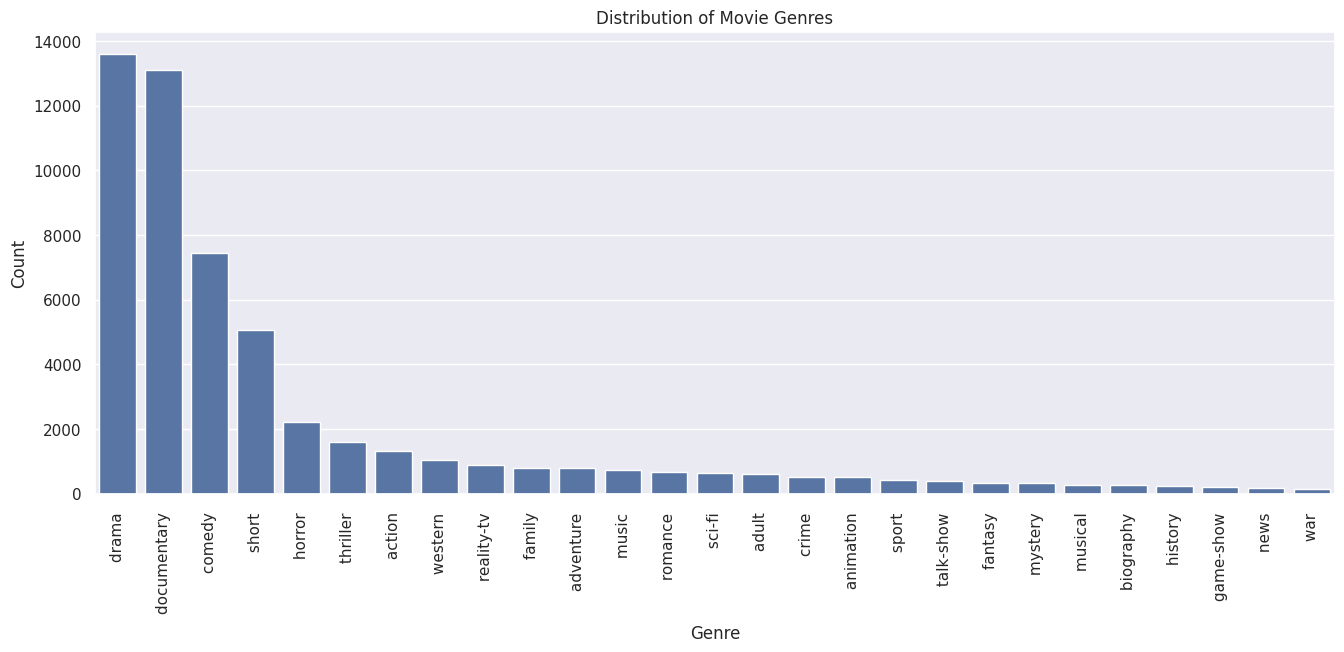

In [ ]:
# Plot the distribution of genres
plt.figure(figsize=(16, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values)
plt.title('Distribution of Movie Genres')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Inspect the length of descriptions
train_data['Description_length'] = train_data['Description'].apply(len)
print(train_data['Description_length'].describe())

count    54214.000000
mean       600.452429
std        446.026620
min         42.000000
25%        325.000000
50%        464.000000
75%        713.000000
max      10504.000000
Name: Description_length, dtype: float64


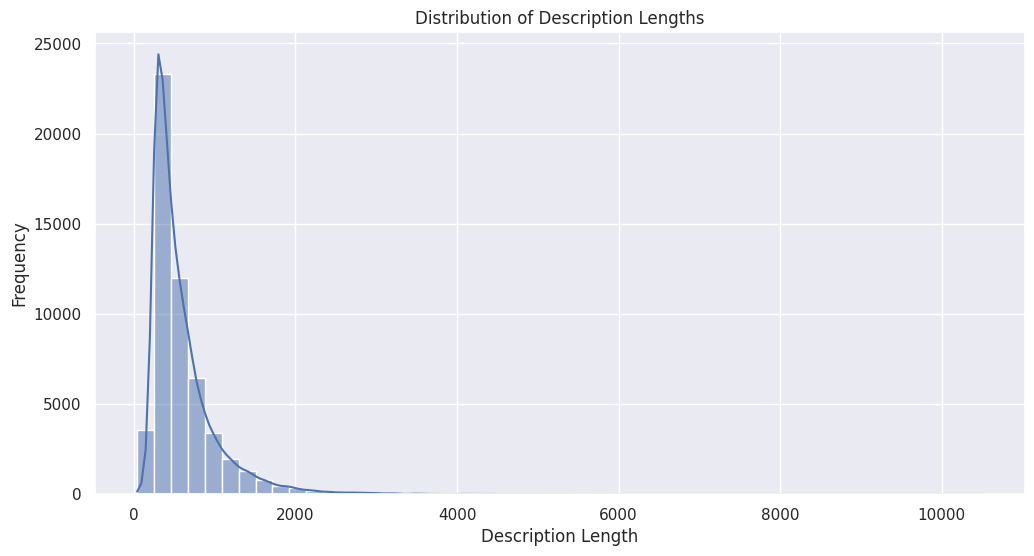

In [ ]:
# Plot the distribution of description lengths
plt.figure(figsize=(12, 6))
sns.histplot(train_data['Description_length'], bins=50, kde=True)
plt.title('Distribution of Description Lengths')
plt.xlabel('Description Length')
plt.ylabel('Frequency')
plt.show()

## Feature Extraction

### Feature Extraction using TF-IDF Vectorization

In [ ]:
# Extract TF-IDF features
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)
X_tfidf = vectorizer.fit_transform(train_data['Description'])
y = train_data['Genre']

print("TF-IDF features shape:", X_tfidf.shape)

TF-IDF features shape: (54214, 120800)


In [ ]:
# Save X_tfidf to a file
np.save('X_tfidf.npy',X_tfidf)
print("X_tfidf features have been saved to X_tfidf.npy")

X_tfidf features have been saved to X_tfidf.npy


### Feature Extraction using Word2Vec Embeddings

In [ ]:
# Load pre-trained Word2Vec model
word2vec_model = api.load('word2vec-google-news-300')

def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    return np.mean(vectorized, axis=0)

def preprocess(text):
    return text.lower().split()

# Convert descriptions to Word2Vec features
X_word2vec = np.array([get_average_word2vec(preprocess(text), word2vec_model) for text in train_data['Description']])

print("Word2Vec features shape:", X_word2vec.shape)

[==================================================] 100.0% 1662.8/1662.8MB downloaded
Word2Vec features shape: (54214, 300)


In [ ]:
# Save X_bert to a file
np.save('X_word2vec.npy', X_word2vec)
print("Word2Vec features have been saved to X_word2vec.npy")

Word2Vec features have been saved to X_word2vec.npy


### Feature Extraction using GloVe Embeddings

In [ ]:
# Function to download and extract GloVe embeddings
def download_glove(url, save_path, extract_path):
    if not os.path.exists(extract_path):
        os.makedirs(extract_path)
    response = requests.get(url)
    with open(save_path, 'wb') as f:
        f.write(response.content)
    with zipfile.ZipFile(save_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    os.remove(save_path)

glove_url = 'http://nlp.stanford.edu/data/glove.6B.zip'
glove_save_path = 'glove.6B.zip'
glove_extract_path = 'glove.6B'

download_glove(glove_url, glove_save_path, glove_extract_path)
print("GloVe embeddings downloaded and extracted.")

GloVe embeddings downloaded and extracted.


In [ ]:
# Load GloVe embeddings
def load_glove_embeddings(file_path):
    embeddings_dict = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings_dict[word] = vector
    return embeddings_dict

glove_file_path = os.path.join(glove_extract_path, 'glove.6B.300d.txt')
glove_embeddings = load_glove_embeddings(glove_file_path)
print("GloVe embeddings loaded.")

GloVe embeddings loaded.


In [ ]:
def preprocess(text):
    # Remove special characters and tokenize
    text = re.sub(r'[^\w\s]', '', text)
    tokens = text.lower().split()
    return tokens

def get_average_glove_embedding(tokens, embeddings, embedding_dim=300):
    valid_tokens = [embeddings[token] for token in tokens if token in embeddings]
    if not valid_tokens:
        return np.zeros(embedding_dim)
    return np.mean(valid_tokens, axis=0)

# Convert descriptions to GloVe embeddings
embedding_dim = 300  # GloVe embedding dimension
descriptions = train_data['Description'].apply(preprocess)
X_glove = np.array([get_average_glove_embedding(tokens, glove_embeddings, embedding_dim) for tokens in descriptions])

print("GloVe features shape:", X_glove.shape)

GloVe features shape: (54214, 300)


In [ ]:
# Save X_glove to a file
np.save('X_glove.npy', X_glove)
print("GloVe features have been saved to X_glove.npy")

GloVe features have been saved to X_glove.npy


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define the path to your Google Drive folder
drive_path = '/content/drive/My Drive/IMDB_Classifier'

# Load arrays with allow_pickle=True
X_tfidf = np.load(os.path.join(drive_path, 'X_tfidf.npy'), allow_pickle=True)
X_word2vec = np.load(os.path.join(drive_path, 'X_word2vec.npy'), allow_pickle=True)
X_glove = np.load(os.path.join(drive_path, 'X_glove.npy'), allow_pickle=True)

print("Arrays have been loaded from Google Drive.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Arrays have been loaded from Google Drive.


## Model Training and Evaluation

In [ ]:
# Encode the genre labels as integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split data into training and testing sets
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, y_encoded, test_size=0.2, random_state=42)
X_train_word2vec, X_test_word2vec, _, _ = train_test_split(X_word2vec, y_encoded, test_size=0.2, random_state=42)
X_train_glove, X_test_glove, _, _ = train_test_split(X_glove, y_encoded, test_size=0.2, random_state=42)

In [ ]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred, zero_division=0))
    print("Accuracy:", accuracy_score(y_test, y_pred))

In [ ]:
# Evaluate models using TF-IDF features
print("Logistic Regression with TF-IDF:")
evaluate_model(LogisticRegression(max_iter=1000), X_train_tfidf, X_test_tfidf, y_train, y_test)

print("SVM with TF-IDF:")
evaluate_model(SVC(), X_train_tfidf, X_test_tfidf, y_train, y_test)

print("Random Forest with TF-IDF:")
evaluate_model(RandomForestClassifier(), X_train_tfidf, X_test_tfidf, y_train, y_test)

# Evaluate XGBoost models
print("XGBoost with TF-IDF:")
evaluate_model(xgb.XGBClassifier(), X_train_tfidf, X_test_tfidf, y_train, y_test)

Logistic Regression with TF-IDF:
              precision    recall  f1-score   support

           0       0.60      0.21      0.31       263
           1       0.86      0.17      0.28       112
           2       0.48      0.10      0.17       139
           3       1.00      0.02      0.04       104
           4       0.00      0.00      0.00        61
           5       0.53      0.59      0.55      1443
           6       1.00      0.01      0.02       107
           7       0.65      0.87      0.74      2659
           8       0.53      0.81      0.64      2697
           9       0.43      0.04      0.07       150
          10       0.00      0.00      0.00        74
          11       0.92      0.28      0.42        40
          12       0.00      0.00      0.00        45
          13       0.68      0.55      0.61       431
          14       0.68      0.35      0.46       144
          15       0.00      0.00      0.00        50
          16       0.00      0.00      0.00     

In [ ]:
# Save the trained models to disk
joblib.dump(LogisticRegression(max_iter=1000), 'logistic_regression_tfidf.pkl')
joblib.dump(SVC(), 'svm_tfidf.pkl')
joblib.dump(RandomForestClassifier(), 'random_forest_tfidf.pkl')
joblib.dump(xgb.XGBClassifier(), 'xgboost_tfidf.pkl')

print("Tfidf models have been saved to disk.")

Tfidf models have been saved to disk.


In [ ]:
# Define the path to your Google Drive folder
drive_path = '/content/drive/My Drive/IMDB_Classifier'

# Save the models to Google Drive
joblib.dump(LogisticRegression(max_iter=1000).fit(X_train_tfidf, y_train), os.path.join(drive_path, 'logistic_regression_tfidf.pkl'))
joblib.dump(SVC().fit(X_train_tfidf, y_train), os.path.join(drive_path, 'svm_tfidf.pkl'))
joblib.dump(RandomForestClassifier().fit(X_train_tfidf, y_train), os.path.join(drive_path, 'random_forest_tfidf.pkl'))
joblib.dump(xgb.XGBClassifier().fit(X_train_tfidf, y_train), os.path.join(drive_path, 'xgboost_tfidf.pkl'))

print("Tfidf models have been saved to Google Drive.")

Tfidf models have been saved to Google Drive.


In [ ]:
# Evaluate models using Word2Vec features
print("Logistic Regression with Word2Vec:")
evaluate_model(LogisticRegression(max_iter=1000), X_train_word2vec, X_test_word2vec, y_train, y_test)

print("SVM with Word2Vec:")
evaluate_model(SVC(), X_train_word2vec, X_test_word2vec, y_train, y_test)

print("Random Forest with Word2Vec:")
evaluate_model(RandomForestClassifier(), X_train_word2vec, X_test_word2vec, y_train, y_test)

print("XGBoost with Word2Vec:")
evaluate_model(xgb.XGBClassifier(), X_train_word2vec, X_test_word2vec, y_train, y_test)

Logistic Regression with Word2Vec:
              precision    recall  f1-score   support

           0       0.46      0.20      0.28       263
           1       0.66      0.17      0.27       112
           2       0.19      0.02      0.04       139
           3       0.00      0.00      0.00       104
           4       0.00      0.00      0.00        61
           5       0.46      0.53      0.49      1443
           6       0.00      0.00      0.00       107
           7       0.63      0.85      0.72      2659
           8       0.51      0.77      0.61      2697
           9       0.57      0.05      0.10       150
          10       0.00      0.00      0.00        74
          11       1.00      0.15      0.26        40
          12       0.00      0.00      0.00        45
          13       0.54      0.43      0.48       431
          14       0.54      0.35      0.42       144
          15       0.00      0.00      0.00        50
          16       0.00      0.00      0.00   

In [ ]:
joblib.dump(LogisticRegression(max_iter=1000), 'logistic_regression_word2vec.pkl')
joblib.dump(SVC(), 'svm_word2vec.pkl')
joblib.dump(RandomForestClassifier(), 'random_forest_word2vec.pkl')
joblib.dump(xgb.XGBClassifier(), 'xgboost_word2vec.pkl')

print("Word2Vec models have been saved to disk.")

In [ ]:
joblib.dump(LogisticRegression(max_iter=1000).fit(X_train_word2vec, y_train), os.path.join(drive_path, 'logistic_regression_word2vec.pkl'))
joblib.dump(SVC().fit(X_train_word2vec, y_train), os.path.join(drive_path, 'svm_word2vec.pkl'))
joblib.dump(RandomForestClassifier().fit(X_train_word2vec, y_train), os.path.join(drive_path, 'random_forest_word2vec.pkl'))
joblib.dump(xgb.XGBClassifier().fit(X_train_word2vec, y_train), os.path.join(drive_path, 'xgboost_word2vec.pkl'))

print("Word2Vec models have been saved to Google Drive.")

Word2Vec models have been saved to Google Drive.


In [ ]:
# Evaluate models using GloVe features
print("Logistic Regression with GloVe:")
evaluate_model(LogisticRegression(max_iter=1000), X_train_glove, X_test_glove, y_train, y_test)

print("SVM with GloVe:")
evaluate_model(SVC(), X_train_glove, X_test_glove, y_train, y_test)

print("Random Forest with GloVe:")
evaluate_model(RandomForestClassifier(), X_train_glove, X_test_glove, y_train, y_test)

print("XGBoost with GloVe:")
evaluate_model(xgb.XGBClassifier(), X_train_glove, X_test_glove, y_train, y_test)

Logistic Regression with GloVe:
              precision    recall  f1-score   support

           0       0.42      0.31      0.36       263
           1       0.67      0.36      0.47       112
           2       0.29      0.15      0.20       139
           3       0.36      0.13      0.20       104
           4       0.00      0.00      0.00        61
           5       0.51      0.55      0.53      1443
           6       0.16      0.03      0.05       107
           7       0.67      0.82      0.74      2659
           8       0.54      0.75      0.63      2697
           9       0.39      0.15      0.22       150
          10       0.50      0.05      0.10        74
          11       0.86      0.45      0.59        40
          12       0.00      0.00      0.00        45
          13       0.57      0.55      0.56       431
          14       0.56      0.52      0.54       144
          15       0.50      0.06      0.11        50
          16       0.50      0.02      0.03      

In [ ]:
joblib.dump(LogisticRegression(max_iter=1000), 'logistic_regression_glove.pkl')
joblib.dump(SVC(), 'svm_glove.pkl')
joblib.dump(RandomForestClassifier(), 'random_forest_glove.pkl')
joblib.dump(xgb.XGBClassifier(), 'xgboost_glove.pkl')

print("GloVe models have been saved to disk.")

GloVe models have been saved to disk.


In [ ]:
joblib.dump(LogisticRegression(max_iter=1000).fit(X_train_glove, y_train), os.path.join(drive_path, 'logistic_regression_glove.pkl'))
joblib.dump(SVC().fit(X_train_glove, y_train), os.path.join(drive_path, 'svm_glove.pkl'))
joblib.dump(RandomForestClassifier().fit(X_train_glove, y_train), os.path.join(drive_path, 'random_forest_glove.pkl'))
joblib.dump(xgb.XGBClassifier().fit(X_train_glove, y_train), os.path.join(drive_path, 'xgboost_glove.pkl'))

print("GloVe models have been saved to Google Drive.")

GloVe models have been saved to Google Drive.


In [ ]:
# Define the path to your Google Drive folder
drive_path = '/content/drive/My Drive/IMDB_Classifier'

In [ ]:
# Load the models from Google Drive
logistic_regression_tfidf = joblib.load(os.path.join(drive_path, 'logistic_regression_tfidf.pkl'))
svm_tfidf = joblib.load(os.path.join(drive_path, 'svm_tfidf.pkl'))
random_forest_tfidf = joblib.load(os.path.join(drive_path, 'random_forest_tfidf.pkl'))
xgboost_tfidf = joblib.load(os.path.join(drive_path, 'xgboost_tfidf.pkl'))

logistic_regression_word2vec = joblib.load(os.path.join(drive_path, 'logistic_regression_word2vec.pkl'))
svm_word2vec = joblib.load(os.path.join(drive_path, 'svm_word2vec.pkl'))
random_forest_word2vec = joblib.load(os.path.join(drive_path, 'random_forest_word2vec.pkl'))
xgboost_word2vec = joblib.load(os.path.join(drive_path, 'xgboost_word2vec.pkl'))

logistic_regression_glove = joblib.load(os.path.join(drive_path, 'logistic_regression_glove.pkl'))
svm_glove = joblib.load(os.path.join(drive_path, 'svm_glove.pkl'))
random_forest_glove = joblib.load(os.path.join(drive_path, 'random_forest_glove.pkl'))
xgboost_glove = joblib.load(os.path.join(drive_path, 'xgboost_glove.pkl'))

print("Models have been loaded from Google Drive.")

Models have been loaded from Google Drive.


In [ ]:
# Collect the accuracy results for each model
results = {
    'Model': ['Logistic Regression', 'SVM', 'Random Forest', 'XGBoost'],
    'TF-IDF': [0.579083279535184, 0.5666328506870792, 0.48870238863783083, 0.5464354883334871],
    'Word2Vec': [0.5412708659964954, 0.5774232223554366, 0.47108733745273446, 0.5368440468505026],
    'GloVe': [0.5689384856589504, 0.5622060315410864, 0.48113990593009315, 0.5405330628054966]
}

# Convert to a DataFrame
df_results = pd.DataFrame(results)

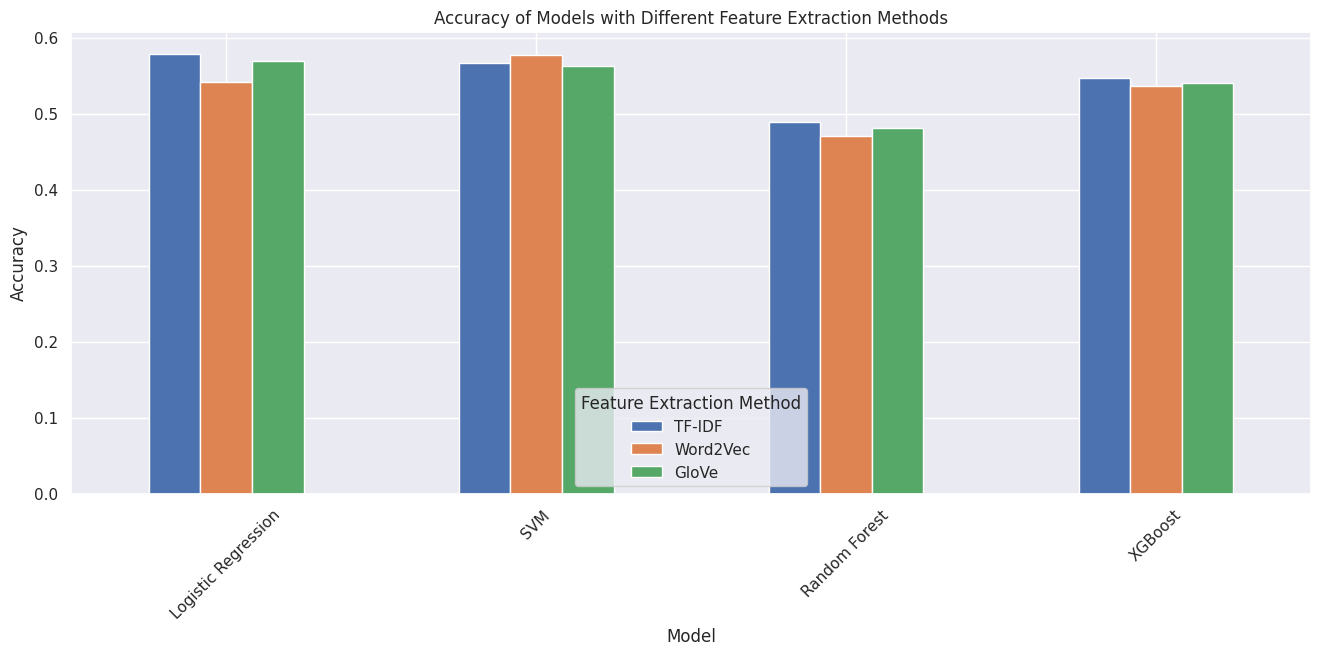

In [ ]:
# Plot accuracy for each model and feature extraction method
fig, ax = plt.subplots(figsize=(16, 6))

df_results.set_index('Model').plot(kind='bar', ax=ax)
plt.title('Accuracy of Models with Different Feature Extraction Methods')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.legend(title='Feature Extraction Method')
plt.show()

In [ ]:
# Metrics for category 8 ('drama') for each model and feature extraction method
metrics_results = {
    'TF-IDF': {
        'Logistic Regression': [0.53, 0.81, 0.64],
        'SVM': [0.49, 0.84, 0.62],
        'Random Forest': [0.42, 0.85, 0.56],
        'XGBoost': [0.50, 0.77, 0.61]
    },
    'Word2Vec': {
        'Logistic Regression': [0.51, 0.77, 0.61],
        'SVM': [0.53, 0.77, 0.63],
        'Random Forest': [0.44, 0.75, 0.55],
        'XGBoost': [0.51, 0.73, 0.60]
    },
    'GloVe': {
        'Logistic Regression': [0.54, 0.75, 0.63],
        'SVM': [0.52, 0.78, 0.62],
        'Random Forest': [0.44, 0.75, 0.56],
        'XGBoost': [0.51, 0.72, 0.60]
    }
}

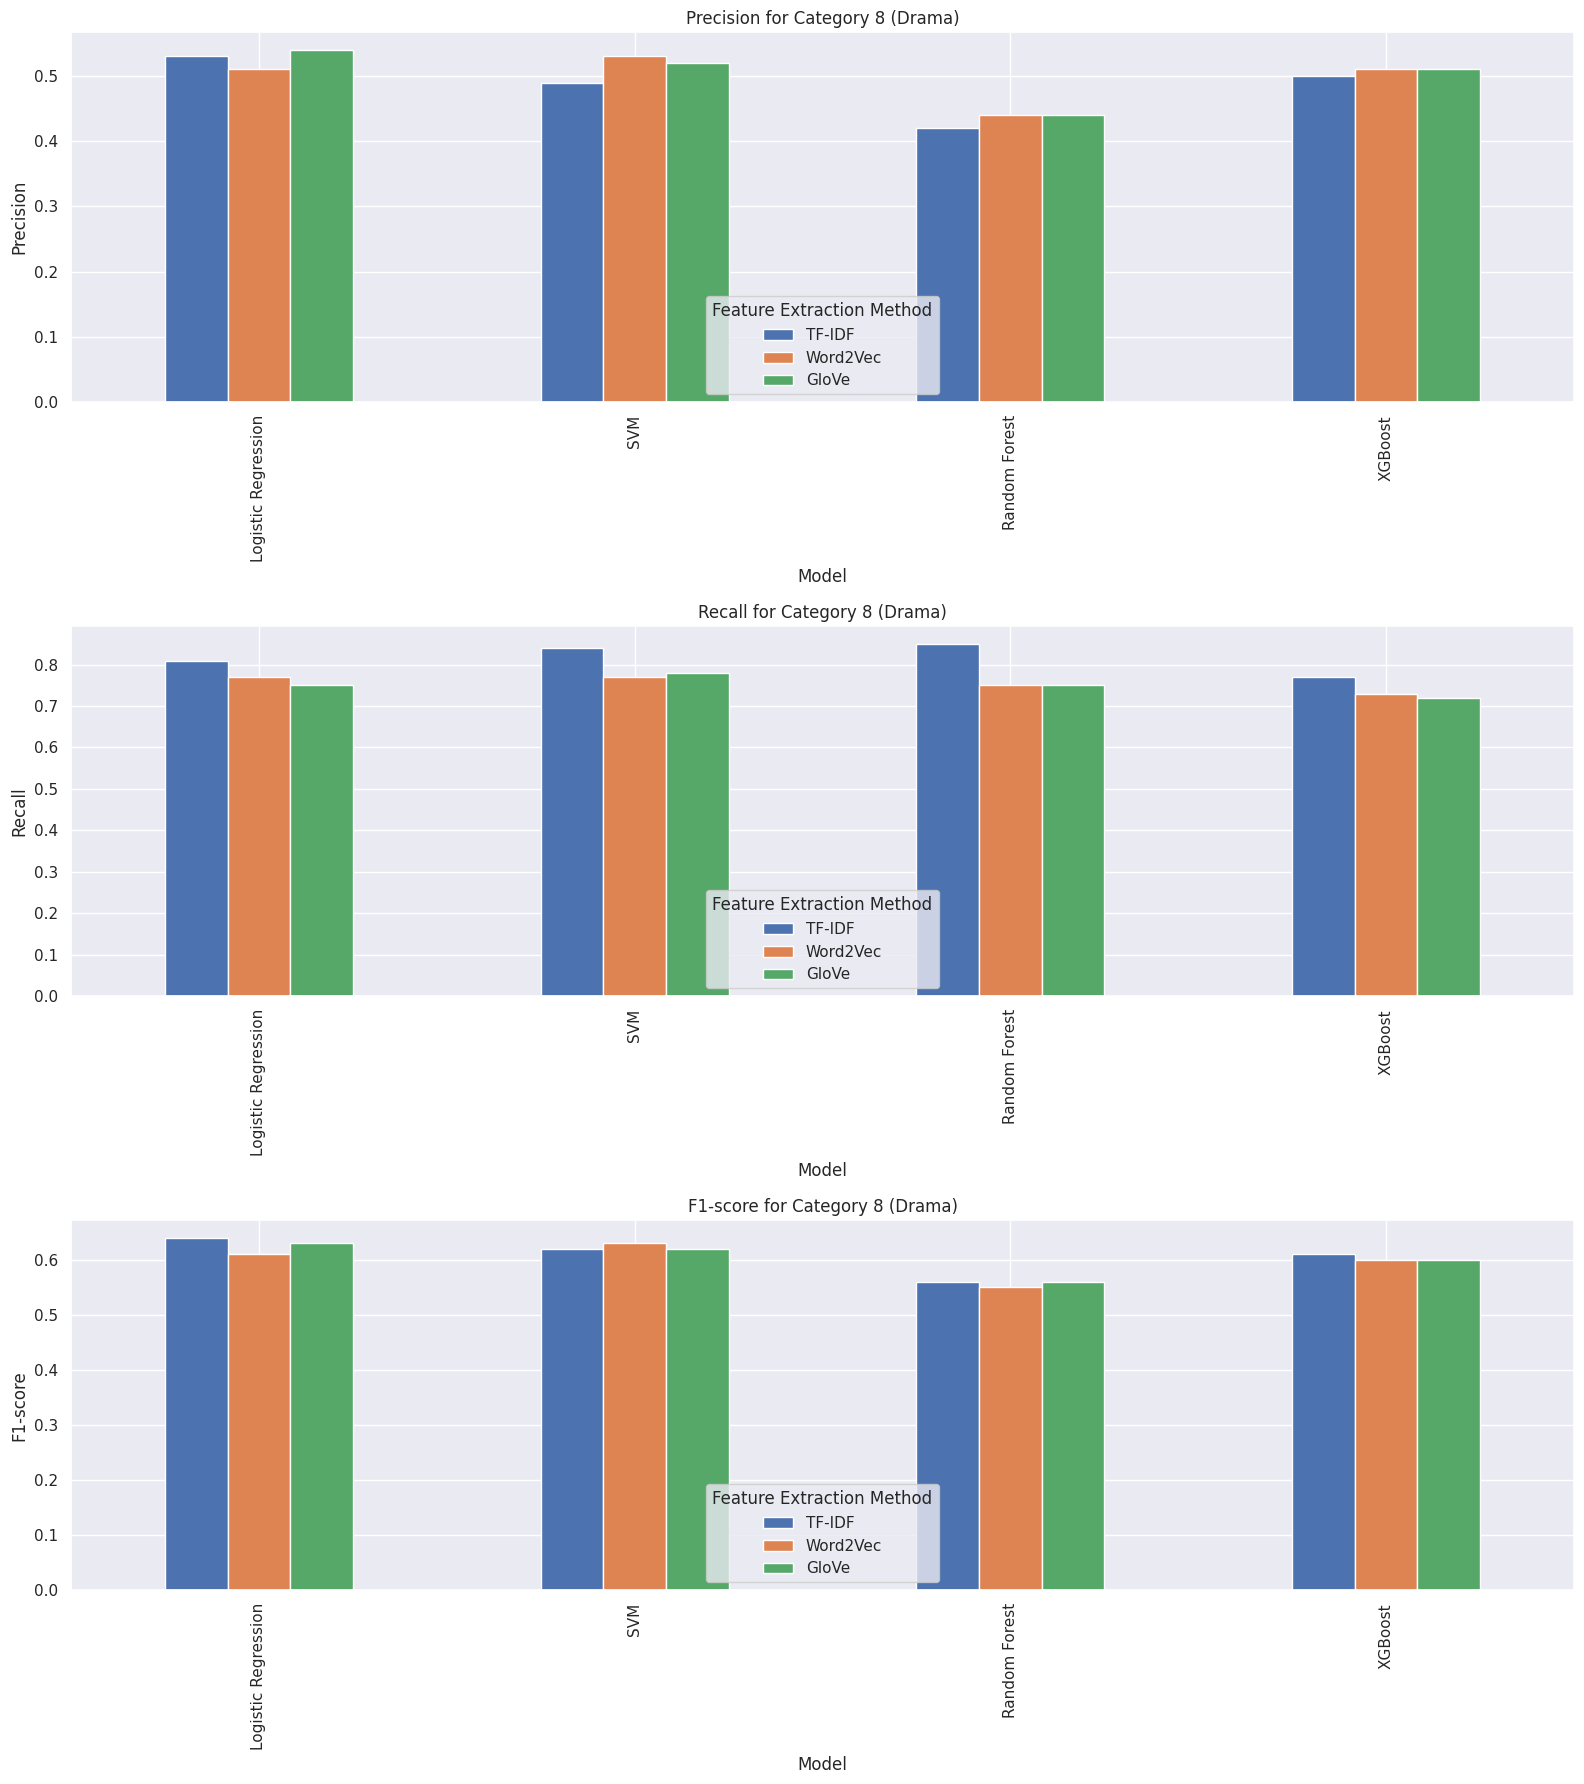

In [ ]:
metrics = ['precision', 'recall', 'f1-score']
fig, axes = plt.subplots(3, 1, figsize=(16, 18))

for i, metric in enumerate(metrics):
    metric_values = {
        'Model': ['Logistic Regression', 'SVM', 'Random Forest', 'XGBoost'],
        'TF-IDF': [metrics_results['TF-IDF'][model][i] for model in metrics_results['TF-IDF']],
        'Word2Vec': [metrics_results['Word2Vec'][model][i] for model in metrics_results['Word2Vec']],
        'GloVe': [metrics_results['GloVe'][model][i] for model in metrics_results['GloVe']]
    }
    df_metric = pd.DataFrame(metric_values)
    df_metric.set_index('Model').plot(kind='bar', ax=axes[i], legend=(i == 0))
    axes[i].set_title(f'{metric.capitalize()} for Category 8 (Drama)')
    axes[i].set_ylabel(metric.capitalize())
    axes[i].set_xlabel('Model')
    axes[i].set_xticks(range(len(df_metric)))
    axes[i].set_xticklabels(df_metric['Model'])
    axes[i].legend(title='Feature Extraction Method')

plt.tight_layout()
plt.show()